# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance


In [1]:
%load_ext autoreload
%autoreload 1
%aimport omic_helpers
%matplotlib inline

from omic_helpers.graph import embedding as graph_embedding
from omic_helpers.graph import clustering as graph_clustering

import multiprocessing

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
#import pacmap
#import trimap
#import pymde
#import dbmap

import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, FactorAnalysis
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from tqdm import tqdm

from scipy.sparse import csr_matrix

import gc

import os
import glob
from tqdm import tqdm

In [2]:
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.random_projection import johnson_lindenstrauss_min_dim as min_dim
from sklearn.kernel_approximation import Nystroem

In [3]:
from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

In [4]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

- [x] 
 * [Sammon mapping](https://arxiv.org/pdf/2009.08136.pdf): 
 * landmark maximum variance unfolding 
 * Landmark MDS
 * [GSOM](https://github.com/CDAC-lab/pygsom/tree/master/gsom):  -> never mind this is a clustering method..
 * SMACOF
 * KernelPCA, PCA, SparsePCA
 * Factor Analysis
 * Isomap
 * Spectral Embedding/Laplacian eigenmap
 * UMAP
 * PacMap
 * t-SNE
 * dbMAP
 * Sammon
 * LLE
 * NMF
 * MDS
 * Trimap
 
- [ ]
 * [IVIS](https://github.com/beringresearch/ivis): [paper](https://www.nature.com/articles/s41598-019-45301-0)
 * [FactorizedEmbeddings](https://github.com/TrofimovAssya/FactorizedEmbeddings): [paper](https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511)
 * [Diffeomap](): diffeomorphic dimensionality reduction Diffeomap
 * HOPE: karateclub
    * custom autoencoder 
    * RankVisu
    * FastMap MDS: https://github.com/shawn-davis/FastMapy
    * MetricMap
    * SparseMap: https://github.com/vene/sparsemap
    * growing curvilinear component analysis
    * curvilinear distance analysis
    * autoencoder NeuroScale
    * PHATE
    * GPLVM
    * FA
    * Nonlinear PCA
    * SDNE 
    * GCN
    * Graph Factorisation
    * [opt-SNE](https://github.com/omiq-ai/Multicore-opt-SNE): 
    *  Poincare embedding : https://github.com/facebookresearch/poincare-embeddings
    * NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
    * https://github.com/benedekrozemberczki/karateclub
    * [GEM benchmark](https://github.com/palash1992/GEM-Benchmark), [GEM git](https://github.com/palash1992/GEM), [GEM paper](https://www.sciencedirect.com/science/article/pii/S0950705118301540)
    * DLRPP: https://www.sciencedirect.com/science/article/pii/S1568494619305496
    * https://github.com/BGU-CS-VIL/DeepDPM
    * https://github.com/pachterlab/MCML



# testsuite
* distance preservation, 
* trustworthiness, 
* topology preservation (https://github.com/scikit-tda, https://github.com/giotto-ai/giotto-tda)


# Ideas

* Use Bolt to accelerate NN-search: https://github.com/dblalock/bolt
* benchmarks: https://www.nature.com/articles/s41598-019-45301-0
* add custom encoder: https://discuss.pytorch.org/t/extracting-reduced-dimension-data-from-autoencoder-in-pytorch/56581


# Test on genomic data

In [5]:
fetch_cancer_data = True
sample_frac = 0.1
transform_data = False

In [6]:
if fetch_cancer_data:
    pan_cancer = pd.read_parquet("/media/koekiemonster/DATA-FAST/genetic_expression/pan_cancer_rna/pan_cancer_rna.parquet")
    pan_cancer = pan_cancer.set_index('index')
    gene_cols = pan_cancer.columns[pan_cancer.columns!='CANCERTYPE']
else:
    # RNA expression data from ~1000 lung cancer patients
    cancer_data = {}
    cancer_types = {}
    #cancer_data['LC'] = pd.read_feather("/media/koekiemonster/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung_RNAex.feather")
    #RNAex.set_index('index', inplace=True)
    #RNAex = RNAex.loc[:, RNAex.columns[RNAex.var(axis=0)>0].values]

    def join_dict(dd: dict, how='inner', ax=1):
        return pd.concat(dd.values(), axis=ax, join=how)

    # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
    for file in glob.glob("/media/koekiemonster/DATA-FAST/genetic_expression/pan_cancer_rna/*/*"):
        dir_name = os.path.basename(os.path.dirname(file))
        cancer_data[dir_name] = \
                    pd.read_csv(file, sep="\t", encoding="utf-8", index_col=0)
        cancer_data[dir_name] = \
                    cancer_data[os.path.basename(os.path.dirname(file))].iloc[1:,:]

        cancer_data[dir_name].columns = [f'{c}_{dir_name}' for c in cancer_data[dir_name].columns]
        cancer_data[dir_name].loc['CANCERTYPE', :] = dir_name
        cancer_types[dir_name] = cancer_data[dir_name].loc['CANCERTYPE', :]

    pan_cancer = join_dict(cancer_data, how='inner', ax=1).T
    pan_cancer_types = join_dict(cancer_types, how='inner', ax=0).T
    gene_cols = pan_cancer.columns[pan_cancer.columns!='CANCERTYPE']

    failed_columns = []
    err_messages = []

    def convert_column_to_float32(col):
        try:
            return col.astype(np.float32)
        except Exception as e:
            failed_columns.append(col)
            err_messages.append(e)
            return col
            
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_cores)
    pan_cancer = pd.concat(pool.map(convert_column_to_float32, [pan_cancer[col] for col in gene_cols]), axis=1) 
    pool.close()
    gc.collect()
    pan_cancer = pan_cancer.join(pan_cancer_types.to_frame(), how='inner')

    pan_cancer.reset_index().to_parquet("/media/koekiemonster/DATA-FAST/genetic_expression/pan_cancer_rna/pan_cancer_rna.parquet")

if sample_frac < 1:
    pan_cancer = pan_cancer.sample(frac=sample_frac, random_state=42)

Text(0.5, 1.0, 'log10(Variance over mean)')

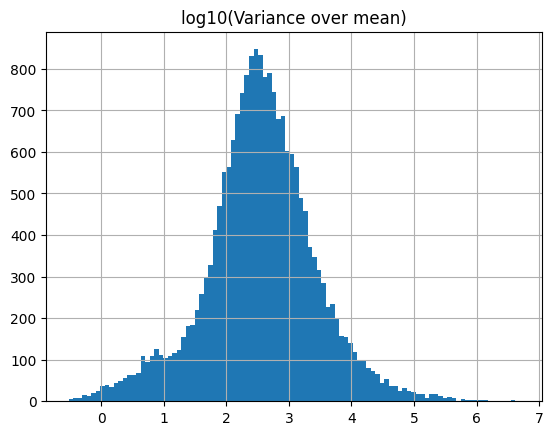

In [7]:
np.log10(pan_cancer.var()/pan_cancer.mean()).hist(bins=100)
plt.title('log10(Variance over mean)')

In [8]:
pan_cancer_qn = pan_cancer.copy()
if transform_data:
    q_clip = lambda x: np.clip(x, np.quantile(x,0.01), np.quantile(x, 0.99))
    _quant_transformer = FunctionTransformer(q_clip)
    _log_transformer = FunctionTransformer(np.log1p)
    log_quant_transformer = Pipeline(steps=[('log', _log_transformer), ('quant', _quant_transformer)])
    tmp = log_quant_transformer().fit_transform(pan_cancer[gene_cols].values)
    pan_cancer_qn.loc[:, gene_cols] = tmp
    del tmp 

    """
    tmp = PowerTransformer(method='yeo-johnson').fit_transform(pan_cancer[gene_cols].values)
    pan_cancer_qn.loc[:, gene_cols] = tmp
    del tmp 
    """
    gc.collect()

In [9]:
# Kruskal-Wallis test
from scipy.stats import kruskal
error_list = []


""" def get_p_values_single(groups):
    try:
        stat, p = kruskal(*groups[1:])
    except Exception as e:
        error_list.append(e)           
        stat, p = np.nan, np.nan
    return {'col':groups[0], 'p': p, 'stat': stat}

def get_p_values(X, var_cols, group_col):
    kw_values = []
    for col in tqdm(var_cols):
        groups = [X.loc[X[group_col]==group, col].values for group in X[group_col].unique()]
        try:
            stat, p = kruskal(*groups)
        except Exception as e:
            error_list.append(e)           
            stat, p = np.nan, np.nan
        kw_values.append({'col':col, 'p': p, 'stat': stat})
    return kw_values

res_kruskall_wallis = pd.DataFrame(get_p_values(pan_cancer_qn, gene_cols, 'CANCERTYPE')) """

#num_cores = multiprocessing.cpu_count()
#pool = multiprocessing.Pool(num_cores)
#groups_list = [[col]+[pan_cancer_qn.loc[pan_cancer_qn['CANCERTYPE']==group, col].values 
#                    for group in pan_cancer_qn['CANCERTYPE'].unique()] 
#                            for col in gene_cols
#            ]
#kw_values = pool.map(get_p_values_single, groups_list)
#pool.close()
#gc.collect()
#res_kruskall_wallis = pd.DataFrame(kw_values)
#gc.collect()

" def get_p_values_single(groups):\n    try:\n        stat, p = kruskal(*groups[1:])\n    except Exception as e:\n        error_list.append(e)           \n        stat, p = np.nan, np.nan\n    return {'col':groups[0], 'p': p, 'stat': stat}\n\ndef get_p_values(X, var_cols, group_col):\n    kw_values = []\n    for col in tqdm(var_cols):\n        groups = [X.loc[X[group_col]==group, col].values for group in X[group_col].unique()]\n        try:\n            stat, p = kruskal(*groups)\n        except Exception as e:\n            error_list.append(e)           \n            stat, p = np.nan, np.nan\n        kw_values.append({'col':col, 'p': p, 'stat': stat})\n    return kw_values\n\nres_kruskall_wallis = pd.DataFrame(get_p_values(pan_cancer_qn, gene_cols, 'CANCERTYPE')) "

In [10]:
num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)
n_landmarks = 75

n_n = 100
reduce_dim = 6
scaler = QuantileTransformer(output_distribution='normal')
embedder_type = 'PCA'


embedder = {}
embedder['nystrom'] = Nystroem(kernel='rbf', n_components=reduce_dim, random_state=1234)
embedder['umap'] = umap.UMAP(n_components=reduce_dim, densmap=True, metric='manhattan',
                             n_neighbors=n_n, min_dist=0., disconnection_distance=None)
#embedder['trimap'] = trimap.TRIMAP(n_dims=reduce_dim, n_iters=2500, lr=0.15);
#embedder['pacmap'] = pacmap.PaCMAP(n_dims=reduce_dim, n_neighbors=n_n)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=reduce_dim, n_neighbors=n_n)
embedder['Isomap'] = Isomap(n_components=reduce_dim)
embedder['MDS'] = MDS(n_components=reduce_dim, metric='euclidean')
embedder['KernelPCA'] = KernelPCA(n_components=reduce_dim, kernel='sigmoid')
embedder['PCA'] = PCA(n_components=reduce_dim)
embedder['SparsePCA'] = SparsePCA(n_components=reduce_dim, alpha=0.0001, n_jobs=8)
embedder['FA'] = FactorAnalysis(n_components=reduce_dim, max_iter=1000, rotation='varimax')
#embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=reduce_dim, n_neighbors=n_n, method='ltsa')
embedder['NMF'] = NMF(n_components=reduce_dim, max_iter=10000)
embedder['TSNE'] = TSNE(n_components=3, perplexity=50)
embedder['Sammon'] = graph_embedding.Sammon(n_components=reduce_dim, n_neighbors=n_n,
                                            max_iterations=250, learning_rate=0.1, init_type='PCA')
embedder['MVU'] = graph_embedding.MaximumVarianceUnfolding(n_components=2, n_neighbors=n_n)
embedder['LMVU'] = graph_embedding.LandmarkMaximumVarianceUnfolding(n_components=reduce_dim, 
                                                                     n_neighbors=n_n, 
                                                                     n_landmarks=n_landmarks)
embedder['LMDS'] = graph_embedding.LandmarkMultiDimensionalScaling(n_components=reduce_dim,
                                                                     n_landmarks=n_landmarks)
embedder['GPR'] = GRP(n_components=reduce_dim, random_state=3231, eps=0.8)


In [11]:
if embedder_type == 'dbmap':
    pipe = Pipeline([('scaler', scaler), 
                     ('prepmap', embedder['dbmap']), 
                     ('reducer', embedder['umap'])])
    tts = embedder['dbmap'].fit_transform(pan_cancer[gene_cols])
    RNAembedded =np.array(pipe.fit_transform(tts))
elif embedder_type == 'NMF':    
    nonnegger = lambda x: x + 2*np.abs(np.min(x, axis=0))
    nonnegger_F = FunctionTransformer(func=nonnegger)

    pipe = Pipeline([('scaler', scaler), 
                     ('nngr', nonnegger_F), 
                     ('reducer', embedder['NMF'])])
    RNAembedded = pipe.fit_transform(pan_cancer[gene_cols])
elif embedder_type == 'SMACOF':
    try:
        dissimilarities;
    except NameError:
        # np.abs(np.log(similarities))
        dissimilarities = distance.squareform(distance.pdist(pan_cancer[gene_cols].values, metric='euclidean'))
    RNAembedded = smacof(dissimilarities, n_components=reduce_dim, max_iter=300, eps=1e-3, n_jobs=4)[0]
else:
    pipe = Pipeline([('scaler', scaler), 
                     ('reducer', embedder[embedder_type])])
    RNAembedded = pipe.fit_transform(pan_cancer_qn[gene_cols])

Text(0.5, 1.0, 'RNAex distance preservation')

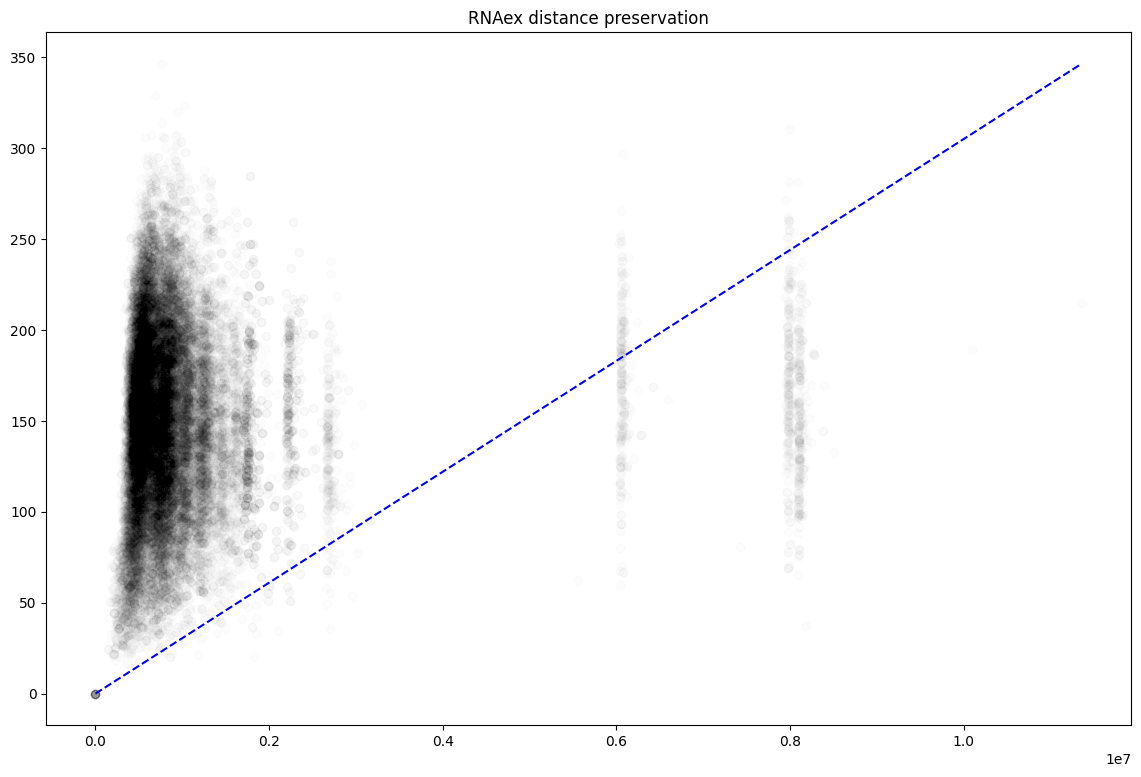

In [12]:
dist_or = get_intra_sample_distances(pan_cancer_qn.iloc[sample_selection, :-1])
dist_emb = get_intra_sample_distances(RNAembedded[sample_selection,:])

dists = {'d_or': dist_or, 'd_emb': dist_emb}
dist_preservation_overall = {'dataset': 'RNAex', 
                          'corr':dcor.distance_correlation(dist_or, dist_emb)}

fig, ax = plt.subplots(figsize=(14,9))
ax.scatter(x=dists['d_or'], y=dists['d_emb'], color='black', alpha=0.01)
mx,my = max(dists['d_or']), max(dists['d_emb'])
ax.plot([0,mx], [0, my], ls='--', c='blue')
ax.set_title('RNAex distance preservation')

# topology preservation?

In [13]:
"""
# Rand/MI clustering
kclusterer1 = KMeans(n_clusters=5)
kclusterer1.fit(scaler.fit_transform(pan_cancer_qn[gene_cols]))

kclusterer2 = KMeans(n_clusters=5)
kclusterer2.fit(RNAembedded)

r_score =rand_score(kclusterer1.labels_, kclusterer2.labels_)
ar_score = adjusted_rand_score(kclusterer1.labels_, kclusterer2.labels_)
mi_score = adjusted_mutual_info_score(kclusterer1.labels_, kclusterer2.labels_)

ch_score1 = calinski_harabasz_score(pan_cancer_qn[gene_cols], kclusterer1.labels_)
ch_score2 = calinski_harabasz_score(RNAembedded, kclusterer2.labels_)

db_score1 = davies_bouldin_score(pan_cancer_qn[gene_cols], kclusterer1.labels_)
db_score2 = davies_bouldin_score(RNAembedded, kclusterer2.labels_)

print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(pan_cancer[gene_cols], RNAembedded))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)
"""

'\n# Rand/MI clustering\nkclusterer1 = KMeans(n_clusters=5)\nkclusterer1.fit(scaler.fit_transform(pan_cancer_qn[gene_cols]))\n\nkclusterer2 = KMeans(n_clusters=5)\nkclusterer2.fit(RNAembedded)\n\nr_score =rand_score(kclusterer1.labels_, kclusterer2.labels_)\nar_score = adjusted_rand_score(kclusterer1.labels_, kclusterer2.labels_)\nmi_score = adjusted_mutual_info_score(kclusterer1.labels_, kclusterer2.labels_)\n\nch_score1 = calinski_harabasz_score(pan_cancer_qn[gene_cols], kclusterer1.labels_)\nch_score2 = calinski_harabasz_score(RNAembedded, kclusterer2.labels_)\n\ndb_score1 = davies_bouldin_score(pan_cancer_qn[gene_cols], kclusterer1.labels_)\ndb_score2 = davies_bouldin_score(RNAembedded, kclusterer2.labels_)\n\nprint("Distance preservation overall", dist_preservation_overall)\nprint("Intra-distance trustworthiness", trustworthiness(pan_cancer[gene_cols], RNAembedded))\nprint("Rand score", r_score)\nprint("Adjusted Rand score", ar_score)\nprint("Adjusted MI score", mi_score)\nprint("

In [14]:
plot_df = pd.DataFrame(data=RNAembedded, columns=['d'+'_'+str(i) for i in range(reduce_dim)], index=pan_cancer.index)
#meta = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_meta.feather")
#meta.set_index('SampleID', inplace=True)
plot_df = plot_df.join(pan_cancer_qn[['CANCERTYPE']], how='left')

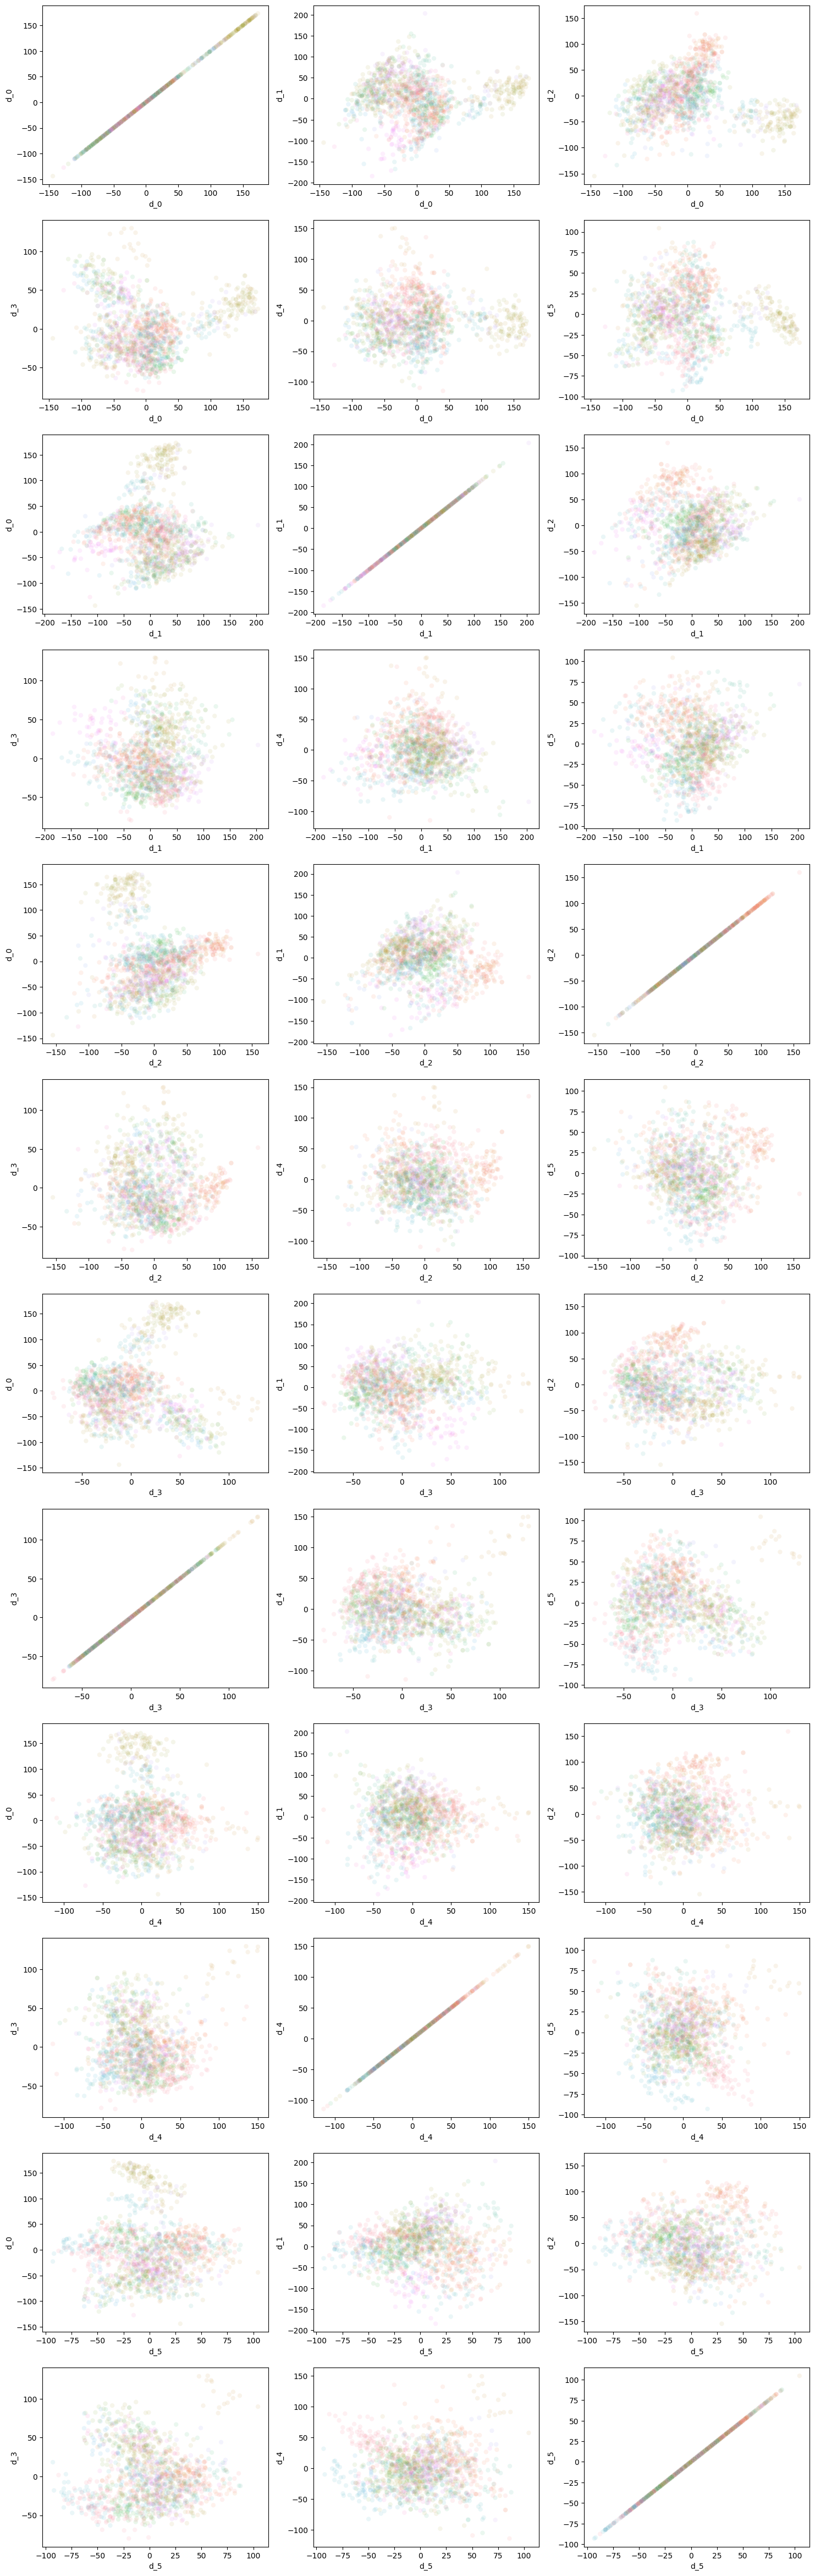

In [15]:
reduce_dim_ = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim_)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim_):
    for kj in range(reduce_dim_): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], hue='CANCERTYPE', alpha=0.1, legend=False)
        else:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], hue='CANCERTYPE', alpha=0.1, legend=False)
        k += 1

In [16]:
gc.collect()

237

## Benchmarking

* dimensionality versus scores

In [17]:
from hembedder.utils import quality_metrics as qm

In [18]:
quality = qm.CDEmbeddingPerformance()

In [19]:
Qmatrix = quality._get_coranking_matrix(X_org=pan_cancer_qn[gene_cols].values[:,:50], X_emb=RNAembedded, backend='ctype')

: 

: 

In [ ]:
Qnx = quality._return_Qnx(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
Qtrust = quality._return_Qtrustworthiness(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
Qcont = quality._return_Qcontinuity(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
Qlcmc = quality._return_LCMC(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
QnMRRE = quality._return_nMRRE(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
QvMRRE = quality._return_vMRRE(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded, Q=Qmatrix)
DistCorr = quality._return_dynamic_distance_correlation(X_org=pan_cancer[gene_cols].values[:,:50], X_emb=RNAembedded)

In [ ]:
dims = np.arange(3, 90,3) # reduced dimensions
km = 5 # k-means clusters
_eps = 0.1

num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)
dist_or = get_intra_sample_distances(RNAex.iloc[sample_selection,:])
    
embedder_type = 'KernelPCA'

clusterer_base = KMeans(n_clusters=km)
clusterer_base.fit(scaler().fit_transform(RNAex))
ch_score1 = calinski_harabasz_score(RNAex, clusterer_base.labels_)
db_score1 = davies_bouldin_score(RNAex, clusterer_base.labels_)

scores = []
for dim in tqdm(dims):    
    _embedder = embedder[embedder_type]
    _embedder.n_components=dim
    
    ref_embedder = GRP(n_components=dim, random_state=3231, eps=_eps) # _eps
    
    pipe = Pipeline([('scaler', scaler()), 
                     ('reducer', _embedder)])
    
    ref_pipe = Pipeline([('scaler', scaler()), 
                     ('reducer', ref_embedder)])
    
    embedding = pipe.fit_transform(RNAex)
    ref_embedding = ref_pipe.fit_transform(RNAex)
    
    clusterer = KMeans(n_clusters=km)
    clusterer.fit(embedding)
    
    ref_clusterer = KMeans(n_clusters=km)
    ref_clusterer.fit(ref_embedding)
    
    ####################
    # get metrics ######
    ####################
    
    dist_emb = get_intra_sample_distances(embedding[sample_selection,:])
    dist_cor = dcor.distance_correlation(dist_or, dist_emb)
    
    trust = trustworthiness(RNAex, embedding)
    
    r_score =rand_score(kclusterer_base.labels_, clusterer.labels_)
    ar_score = adjusted_rand_score(kclusterer_base.labels_, clusterer.labels_)
    mi_score = adjusted_mutual_info_score(kclusterer_base.labels_, clusterer.labels_)
    
    ch_score2 = calinski_harabasz_score(embedding, clusterer.labels_)
    db_score2 = davies_bouldin_score(embedding, clusterer.labels_)
    
    rel_ch_score = ch_score1/ch_score2
    rel_db_score = db_score1/db_score2
        
    scores.append({'dim':dim, 'dist_cor': dist_cor, 'trust': trust,
                   'rand': r_score, 'adj_rand': ar_score, 'adj_mi': mi_score,
                   'ch_score': ch_score2, 'db_score': db_score2, 
                   'rel_ch_score': rel_ch_score , 'rel_db_score': rel_db_score,                   
                   'embedder': embedder_type})
    
    
    dist_emb = get_intra_sample_distances(ref_embedding[sample_selection,:])
    dist_cor = dcor.distance_correlation(dist_or, dist_emb)
    
    trust = trustworthiness(RNAex, ref_embedding)
    
    r_score =rand_score(kclusterer_base.labels_, ref_clusterer.labels_)
    ar_score = adjusted_rand_score(kclusterer_base.labels_, ref_clusterer.labels_)
    mi_score = adjusted_mutual_info_score(kclusterer_base.labels_, ref_clusterer.labels_)
    
    ch_score2 = calinski_harabasz_score(embedding, ref_clusterer.labels_)
    db_score2 = davies_bouldin_score(embedding, ref_clusterer.labels_)

    rel_ch_score = ch_score1/ch_score2
    rel_db_score = db_score1/db_score2
    
    scores.append({'dim':dim, 'dist_cor': dist_cor, 'trust': trust,
                   'rand': r_score, 'adj_rand': ar_score, 'adj_mi': mi_score,
                   'ch_score': ch_score2, 'db_score': db_score2,                    
                   'rel_ch_score': rel_ch_score , 'rel_db_score': rel_db_score,   
                   'embedder': 'GRP'})
scores_df = pd.DataFrame(scores)

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(17,18))
sns.lineplot(data=scores_df, x='dim', y='dist_cor', hue='embedder', ax=ax[0,0])
sns.lineplot(data=scores_df, x='dim', y='trust', hue='embedder', ax=ax[0,1])
sns.lineplot(data=scores_df, x='dim', y='rand', hue='embedder', ax=ax[0,2])

sns.lineplot(data=scores_df, x='dim', y='adj_rand', hue='embedder', ax=ax[1,0])
sns.lineplot(data=scores_df, x='dim', y='adj_mi', hue='embedder', ax=ax[1,1])
sns.lineplot(data=scores_df, x='dim', y='ch_score', hue='embedder', ax=ax[1,2])

sns.lineplot(data=scores_df, x='dim', y='db_score', hue='embedder', ax=ax[2,0])
sns.lineplot(data=scores_df, x='dim', y='rel_ch_score', hue='embedder', ax=ax[2,1])
sns.lineplot(data=scores_df, x='dim', y='rel_db_score', hue='embedder', ax=ax[2,2])

fig.suptitle(f"Embedder type: {embedder_type}")


# Neural networks for embeddings

work in progress

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor
from torchvision import datasets

In [ ]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(f"Using: {device}")

In [ ]:
class DenseEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(DenseEncoder, self).__init__()
        
        layer_sizes = [in_features] + layer_sizes
        
        self.seq= nn.Sequential()       
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('ENC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('ENC_relu_'+str(idx), nn.ReLU())
        self.seq.add_module('ENC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=out_features))
        
    def forward(self, x):
        return self.seq(x) 

class DenseDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(DenseDecoder, self).__init__()
        
        layer_sizes = list(reversed(layer_sizes))
        layer_sizes = [out_features] + layer_sizes
        
        self.seq= nn.Sequential()
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('DEC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('DEC_relu_'+str(idx), nn.ReLU())
        self.seq.add_module('DEC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=in_features))
        
    def forward(self, x):
        return F.selu(self.seq(x))  
    
class DenseAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(DenseAE, self).__init__()
        self.encoder = DenseEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = DenseDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvEncoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=3, stride=1, padding=0, 
                      bias=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.seq(x) 

class ConvDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvDecoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.ConvTranspose1d(in_channels=out_features, out_channels=64, kernel_size=3, stride=1, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8, stride=4, padding=0, 
                               bias=True)
        )
        
    def forward(self, x):
        return self.seq(x) 
    
class ConvAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(ConvAE, self).__init__()
        self.encoder = ConvEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = ConvDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class MixedColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
    """
    def __init__(self, df, cat_flds):       
        conts = [c.values for n,c in df.items()]
        
        n = len(conts[0])
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.len = len(df)
        
    def __len__(self): 
        return self.len   
    
    def __getitem__(self, idx):
        return self.conts[idx]

In [ ]:
RNAex_normalised = pd.DataFrame(data=StandardScaler().fit_transform(RNAex.values), 
                                columns=RNAex.columns.tolist())
dense_net = DenseAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[32,16])
dense_net.to(device)

conv_net = ConvAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[32,16])
conv_net.to(device)



NUM_EPOCHS = 10
LEARNING_RATE = 1e-2

criterion = nn.MSELoss()
#criterion = nn.binary_cross_entropy()
conv_optimizer = optim.Adam(conv_net.parameters(), lr=LEARNING_RATE)
dense_optimizer = optim.Adam(dense_net.parameters(), lr=LEARNING_RATE)

In [ ]:
train_dl = DataLoader(MixedColumnarDataset(RNAex_normalised, []), batch_size=1)

In [ ]:
dense_net

In [ ]:
outputs = None
def get_embeddings(model, x):
    return model.encoder.forward(Tensor(x)).detach().numpy()

def train(net, trainloader, NUM_EPOCHS, ntype='conv'):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            if ntype=='conv':
                dataTensor = Tensor(data).unsqueeze(0)
                conv_optimizer.zero_grad()            
                outputs = conv_net(dataTensor)
                loss = criterion(outputs, dataTensor)
            else:
                dense_optimizer.zero_grad()            
                outputs = dense_net(data)
                loss = criterion(outputs, data)                
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print(f"-------------Train loss: {loss}, epoch: {epoch}")

    return train_loss

In [ ]:
# train the network
train_loss = train(conv_net, train_dl, NUM_EPOCHS, ntype='conv')

In [ ]:
embs = get_embeddings(conv_net, RNAex_normalised.values)

In [ ]:
plot_df = pd.DataFrame(data=embs, columns=['d_'+str(i) for i in range(reduce_dim)])
sns.scatterplot(data=plot_df, x='d_1', y='d_2')

The distance correlation/preservation and the trustworthiness metrics are not suitable metrics to qualify embeddings as they cannot distinguish between neighborhoods in the original space. Even if points are projected randomly they can have similar distances in lower dimensional space, in fact the higher the dimensionality of the embeddeds space the more possibilities there are to randomly obtain similar intra-point distances.

We would expect that if we increase the embedded dimensions we get closer to the performance of random projections in terms of intra-distance preservations.

# Test on CELLDYN data

# Semi-supervised UMAP

The main flavor is to add labels for the different clusters we know we want to 
see. This can be based on a clustering on a sample set of the original data (perhaps also a selection of features).

# Parametric UMAP

* Create nearest-neighbor graph with fuzzy simplicials
* Apply graph embedder

# Anchored embedding

# Distance preserving embedding

* Siamese twins networks
* distance as outcome
* pairs as input

The method IVIS seems to use this idea.

# Ranking based embedder

# Multi-patch UMAP

The core assumption of UMAP is that all points lie on the same manifold. What if we split our data in dense patches prior to the creation of the fuzzy simplicials? 

To make this tractable this split should be computationally in-expensive. One way to go about is to treat overlapping regions with a sufficient number of samples as patches. The embeddings associated with these patches can later be combined.



# Multi-sample UMAP


* $N$ sampled UMAP embedders with/without minimal perturbations
* aligned using Procrustes
* uniform scaling
* concensus distance determination

# Landmarkbased embeddings coupled to sparse exemplar finders

Instead of random landmarks we can use exemplars based on 
* points closest to centroids
* exemplars based on e.g. affinity propagation